# Introduction
* Through the COVID-19 outbreak, many countries have adopted different strategies to control the infection rate of the virus. Many health organizations released datasets, which contain information about infected, recovered and deceased cases in several countries, and the corresponding measures, which have been taken in each country.	
* Can the effect of measures taken in each country be quantified? How to predict the course of the pandemic? And is it possible to estimate the rates of COVID-19 using the implemented model? 
* With this approach in mind we implemented an epidemiological compartmental model, to estimate the rates of COVID-19 using the data of reported infected, recovered and deceased cases in each country. Additionally, we used the effective reproduction number to quantify the effectiveness of taken measures and the impact of social interventions such as social lockdown or closure of schools on the number of reported infected cases in Germany, Italy and Spain. 

## Importing essential libraries

In [ ]:
import pandas as pd
import numpy as np
import sqlite3 as sql
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
!pip install lmfit
import lmfit

# Model

## SEIQRDP Model
We implemented an epidemiological compartmental model andused the Least Squares Error (LSE) method to fit the model to data. 

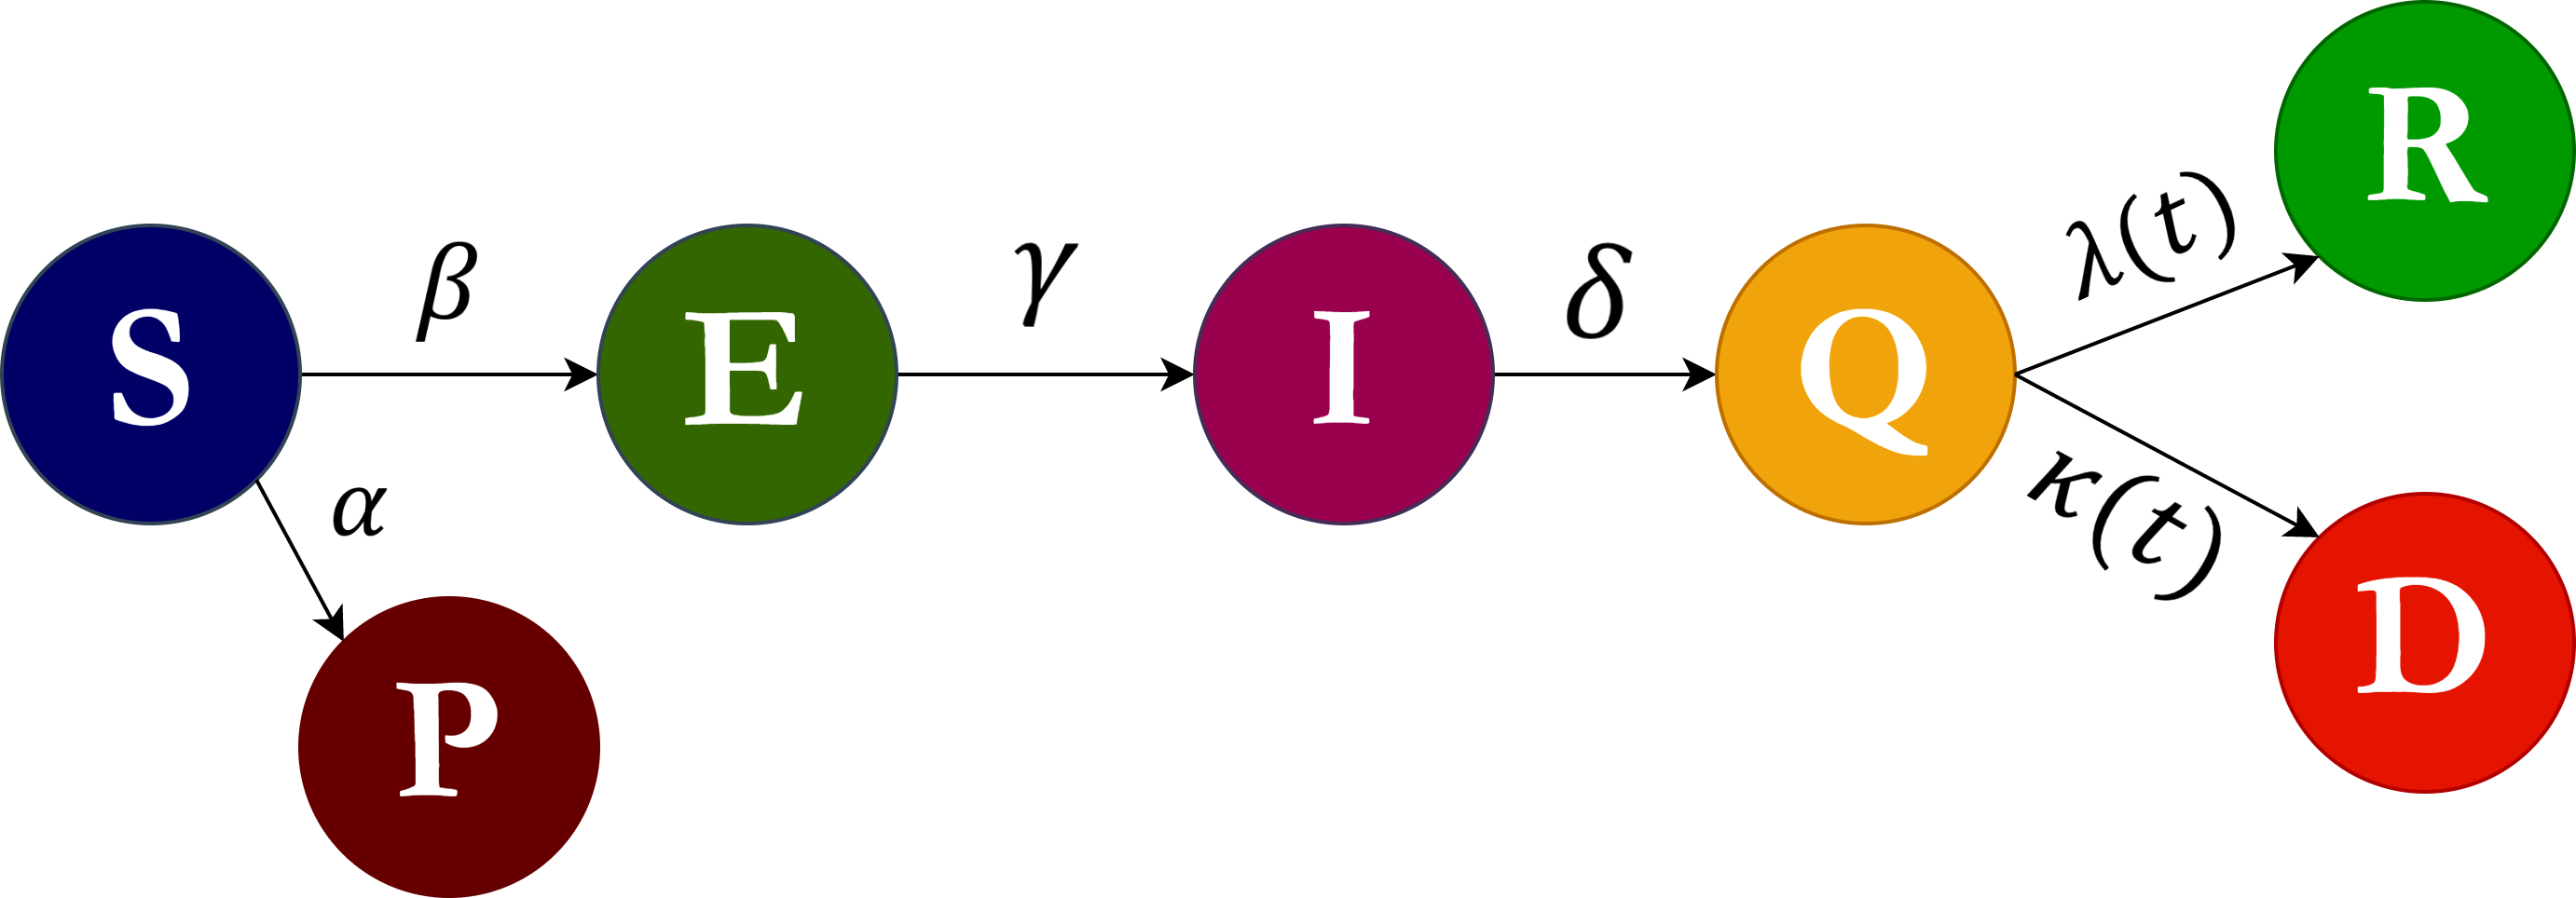

This model consists of seven compartments of the population of a country <br>
{$S(t), E(t), I(t), Q(t), R(t), D(t), P(t)$} denoting time by $t$, with the following states:
*     $S\rightarrow Susceptible$
*     $E\rightarrow Exposed$
*     $I\rightarrow Infected$
*     $Q\rightarrow Quarantined$
*     $R\rightarrow Recovered$
*     $D\rightarrow Deceased$
*     $P\rightarrow Insusceptible$    

Using this model, we assumed that a secondary infection in the investigated timespan is so unlikely that it does not warrant consideration here. Moreover the model is implemented under the assumption that every person with a positive test result goes to quarantine.

These states are connected via six transition parameters, each representing the rate of passing over from a state to the next one.

* $\alpha\rightarrow$ Protection rate
* $\beta\rightarrow$ Infection rate
* $\gamma\rightarrow$ Inverse of the average latent time 
* $\delta\rightarrow$ The rate at which infectious people enter in quarantine
* $\lambda(t)\rightarrow$ Time-dependent coefficient for recovery rate
* $\kappa(t)\rightarrow$ Time-dependent coefficient for mortality rate

Depending on whether the recovery or mortality rate in the corresponding timespan is ascending or descending, one of the three following functions is selected to fit the changes in the parameters:

\begin{equation*}
 \lambda (t)=\qquad	
 \left\{
 \begin{array}{c1}
	\dfrac{\lambda_{0}}{1 + e^{-\lambda_{1} (t + \lambda_{2})}}  \\ \\
	\lambda_{0} + e^{-\lambda_{1} (t + \lambda_{2})} \\ \\
    \lambda_{0} e^{-\lambda_{1} (t - \lambda_{2})^{2}}
 \end{array}
	\right.
\end{equation*}
where $\lambda_{0}$, $\lambda_{1}$ and $\lambda_{2}$ are empirical coefficients. 

\begin{equation*}
 \kappa (t)=\qquad	
 \left\{
 \begin{array}{c1}
	\dfrac{\kappa_{0}}{1 + e^{-\kappa_{1} (t + \kappa_{2})}}  \\ \\
	\kappa_{0} + e^{-\kappa_{1} (t + \kappa_{2})} \\ \\
    \kappa_{0} e^{-\kappa_{1} (t - \kappa_{2})^{2}}
 \end{array}
	\right.
\end{equation*}
where $\kappa_{0}$, $\kappa_{1}$ and $\kappa_{2}$ are empirical coefficients. 

## Priors for the transition parameters 
According to the [Robert Koch Institute](https://edoc.rki.de/handle/176904/6547.2), we initialize the transition parameters $\alpha$, $\beta$ and $\gamma$ with the values 0.05, 0.4, and 0.4. To initialize the coefficients $\lambda_{0}$, $\lambda_{1}$ and $\lambda_{2}$ such as $\kappa_{0}$, $\kappa_{1}$ and $\kappa_{2}$ we first fitted the model with data from the first ten days and then we perform the fitting for the whole dataset in ten days periods.

## Mathematical model
The dynamics of the above states and transition parameters are mathematically characterized by ordinary differential equations (ODE) as follows:
\begin{equation*}
 \qquad	
 \left\{
 \begin{array}{l0.5}
	\dfrac{dS(t)}{dt} = -\alpha S(t) - \beta \dfrac{S(t)I(t)}{N} \\ 
    \dfrac{dE(t)}{dt} = -\gamma E(t) + \beta \dfrac{S(t)I(t)}{N} \\ 
    \dfrac{dI(t)}{dt} = \gamma E(t) - \delta I(t) \\ 
    \dfrac{dQ(t)}{dt} = \delta I(t) - \lambda (t) Q(t) - \kappa (t) Q(t) \\ 
    \dfrac{dR(t)}{dt} = \lambda (t) Q(t) \\ 
    \dfrac{dD(t)}{dt} = \kappa (t) Q(t) \\ 
    \dfrac{dP(t)}{dt} = \alpha S(t) \\ 
 \end{array}
       \right.
\end{equation*}
where $N$ corresponds to the population of the considered country and it can be expressed as $S + E + I + Q + R + D + P = N$

## Effective reproduction number
The effective reproduction number $R(t) = \beta\delta^{-1}S(t)/N$ is a strong tool to evaluate the intensity of interventions required to control the spread of the virus. Generally, $R(t)>1$ corresponds to $\dfrac{dI(t)}{dt} + \dfrac{dE(t)}{dt} >1$, which can be interpreted as the epidemical spread of disease. Similarly, $R(t)<1$ corresponds to controlling the spread of the disease.

In [ ]:
# Functions of equations

def getlambda(tspan, Q, R, initial_guess):
    """
    Parameters
    ----------
    tspan : numpy.ndarray
        time vector [days,].
    Q : numpy.ndarray
        time series of quarantiened cases [days,].
    R : numpy.ndarray
        time series of recovered cases [days,].
    initial_guess: list
        list of initial guess for the parameters lambda0, lambda1, lambda2
        
    Returns
    -------
    lambda0 : float
        estimated value of lambda0.
    lambda1 : float
        estimated value of lambda1.
    lambda2 : float
        estimated value of lambda2.
    lambdafun : function
        estimation function for lambdafun(lambda0, lambda1, lambda2, time_span)

    """
    if np.max(R)<20:                    # Assumption: Recovered cases less than 20 can either increase or decrease
        lambdafun = lambda l0,l1,l2,t: l0 *np.exp(-(l1 *(t - l2)) **2)       # Hill-shaped sigmoide fuction
        rate = (np.diff(R)/np.median(np.diff(tspan[:])))/Q[1:]
        x = tspan[1:]
        if initial_guess == []:  
            lambda0 = np.max(rate)
            lambda1 = 0.5
            lambda2 = len(tspan)/2
        else:
            lambda0, lambda1, lambda2 = initial_guess
        params = lmfit.Parameters()
        if np.max(rate)< 1e-10:   # To prevent dividing by zero
            params.add('lambda0',lambda0,min=0,max=1)
            print('\nWarning! Recovery rate is too low for Lambda estimation. Poor estimation is expected!\n')
        else:
            params.add('lambda0',lambda0,min=0,max=np.max(rate))
        params.add('lambda1',lambda1,min=0,max=1)
        params.add('lambda2',lambda2,min=0,max=100)
        res1 = lambda params, rate, x: lambdafun(params['lambda0'].value,params['lambda1'].value,params['lambda2'].value,x) - rate
        
        fit1 = lmfit.minimize(res1,params,args=(rate,x),method='least_squares')
        lambda0 = fit1.params['lambda0'].value
        lambda1 = fit1.params['lambda1'].value
        lambda2 = fit1.params['lambda2'].value
        # lmfit.report_fit(fit1)

    else: 
        myfun1 = lambda l0,l1,l2,t: l0/(1+np.exp(-l1*(t-l2)))            # Ascending sigmoide function
        myfun2 = lambda l0,l1,l2,t: l0 + np.exp(-l1 *(t + l2))           # Descending sigmoide function
        myfun3 = lambda l0,l1,l2,t: l0 *np.exp(-(l1 *(t - l2)) **2)      # Hill-shaped sigmoide function
    
        rate = (np.diff(R)/np.median(np.diff(tspan[:])))/Q[1:]
        x = tspan[1:]
          
        if initial_guess == []:  
            lambda0 = np.max(rate)
            lambda1 = 0.5
            lambda2 = len(tspan)/2
        else:
            lambda0, lambda1, lambda2 = initial_guess
            
        params = lmfit.Parameters()
        if np.max(rate)< 1e-10:   # To prevent dividing by zero
            params.add('lambda0',lambda0,min=0,max=1)
            print('\nWarning! Recovery rate is too low for Lambda estimation. Poor estimation is expected!\n')
        else:
            params.add('lambda0',lambda0,min=0,max=np.max(rate))
  
        params.add('lambda1',lambda1,min=0,max=1)
        params.add('lambda2',lambda2,min=0,max=100)
        res1 = lambda params, rate, x: myfun1(params['lambda0'].value,params['lambda1'].value,params['lambda2'].value,x) - rate
        res2 = lambda params, rate, x: myfun2(params['lambda0'].value,params['lambda1'].value,params['lambda2'].value,x) - rate
        res3 = lambda params, rate, x: myfun3(params['lambda0'].value,params['lambda1'].value,params['lambda2'].value,x) - rate
        
        fit1 = lmfit.minimize(res1,params,args=(rate,x),method='least_squares')
        lf10 = fit1.params['lambda0'].value
        lf11 = fit1.params['lambda1'].value
        lf12 = fit1.params['lambda2'].value
        lamda1 = myfun1(lf10,lf11,lf12,x)
        dlambda1 = abs(lamda1[0]-lamda1[-1])
        # lmfit.report_fit(fit1)
        
        fit2 = lmfit.minimize(res2,params,args=(rate,x),method='least_squares')
        lf20 = fit2.params['lambda0'].value
        lf21 = fit2.params['lambda1'].value
        lf22 = fit2.params['lambda2'].value
        lamda2 = myfun2(lf20,lf21,lf22,x)
        dlambda2 = abs(lamda2[0]-lamda2[-1])
        # lmfit.report_fit(fit2)
        
        fit3 = lmfit.minimize(res3,params,args=(rate,x),method='least_squares')
        lf30 = fit3.params['lambda0'].value
        lf31 = fit3.params['lambda1'].value
        lf32 = fit3.params['lambda2'].value
        lamda3 = myfun3(lf30,lf31,lf32,x)
        dlambda3 = abs(lamda3[0]-lamda3[-1])
        # lmfit.report_fit(fit2)
        
        if  (dlambda1>dlambda2) and (dlambda1>dlambda2):
            lambdaGuess = [lf10,lf11,lf12]
            lambdafun = myfun1

        elif (dlambda2>dlambda1) and (dlambda2>dlambda3): 
            lambdaGuess = [lf20,lf21,lf22]
            lambdafun = myfun2

        else:
            lambdaGuess = [lf30,lf31,lf32]
            lambdafun = myfun3

        lambda0, lambda1, lambda2 = lambdaGuess
    return lambda0, lambda1, lambda2, lambdafun


def getkappa(tspan, Q, D, initial_guess):
    """
    Parameters
    ----------
    tspan : numpy.ndarray
        time vector [days,].
    D : numpy.ndarray
        time series of death cases [days,].
    R : numpy.ndarray
        time series of recovered cases [days,].
    initial_guess: list
        list of initial guess for the parameters kappa0, kappa1, kappa2
    Returns
    -------
    lambda0 : float
        estimated value of lambda0.
    lambda1 : float
        estimated value of lambda1.
    lambda2 : float
        estimated value of lambda2.
    lambdafun : function
        estimation function for lambdafun(lambda0, lambda1, lambda2, time_span)

    """
    if np.max(D)<10:      # Assumption: Deceased cases less than 10 can either increase or decrease
        kappafun = lambda k0,k1,k2,t: k0 *np.exp(-(k1 *(t - k2)) **2)   # Hill-shaped sigmoide function
        rate = (np.diff(D)/np.median(np.diff(tspan[:])))/Q[1:]
        x = tspan[1:]
        if initial_guess == []:
            kappa0 = np.max(rate)
            kappa1 = 0.5
            kappa2 = len(tspan)/2 
        else:
            kappa0, kappa1, kappa2 = initial_guess
        params = lmfit.Parameters()
        if np.max(rate)< 1e-10:   # To prevent dividing by zero
            params.add('kappa0',kappa0,min=0,max=1)
            print('\nWarning! Mortality rate is too low for Kappa estimation. Poor estimation is expected!\n')
        else:
            params.add('kappa0',kappa0,min=0,max=np.max(rate))
  
        params.add('kappa0',kappa0,min=0,max=np.max(rate))
        params.add('kappa1',kappa1,min=0,max=1)
        params.add('kappa2',kappa2,min=0,max=len(tspan))

        res1 = lambda params, rate, x: kappafun(params['kappa0'].value,params['kappa1'].value,params['kappa2'].value,x) - rate
        
        fit1 = lmfit.minimize(res1,params,args=(rate,x),method='least_squares')
        kappa0 = fit1.params['kappa0'].value
        kappa1 = fit1.params['kappa1'].value
        kappa2 = fit1.params['kappa2'].value
        # lmfit.report_fit(fit1)


    else:
        myfun1 = lambda k0,k1,k2,t: k0 /(1 + np.exp(-k1 *(t - k2)))            # Ascending sigmoide function
        myfun2 = lambda k0,k1,k2,t: k0 + np.exp(-k1 *(t + k2))                 # Descending sigmoide function
        myfun3 = lambda k0,k1,k2,t: k0 *np.exp(-(k1 *(t - k2)) **2)            # Hill-shaped sigmoide function
        rate = (np.diff(D)/np.median(np.diff(tspan[:])))/Q[1:]
        x = tspan[1:]
        if initial_guess == []:
            kappa0 = np.max(rate)
            kappa1 = 0.5
            kappa2 = 2 
        else:
            kappa0, kappa1, kappa2 = initial_guess        
        params = lmfit.Parameters()
        if np.max(rate)< 1e-10:   # To prevent dividing by zero
            params.add('kappa0',kappa0,min=0,max=1)
            print('\nWarning! Mortality rate is too low for Kappa estimation. Poor estimation is expected!\n')
        else:
            params.add('kappa0',kappa0,min=0,max=np.max(rate))
        params.add('kappa1',kappa1,min=0,max=1)
        params.add('kappa2',kappa2,min=0,max=len(tspan))
        res1 = lambda params, rate, x: myfun1(params['kappa0'].value,params['kappa1'].value,params['kappa2'].value,x) - rate
        res2 = lambda params, rate, x: myfun2(params['kappa0'].value,params['kappa1'].value,params['kappa2'].value,x) - rate
        res3 = lambda params, rate, x: myfun3(params['kappa0'].value,params['kappa1'].value,params['kappa2'].value,x) - rate

        fit1 = lmfit.minimize(res1,params,args=(rate,x),method='least_squares')
        kf10 = fit1.params['kappa0'].value
        kf11 = fit1.params['kappa1'].value
        kf12 = fit1.params['kappa2'].value
        kappa1 = myfun1(kf10,kf11,kf12,x)
        dkappa1 = abs(kappa1[0]-kappa1[-1])
        # lmfit.report_fit(fit1)
        
        fit2 = lmfit.minimize(res2,params,args=(rate,x),method='least_squares')
        kf20 = fit2.params['kappa0'].value
        kf21 = fit2.params['kappa1'].value
        kf22 = fit2.params['kappa2'].value
        kappa2 = myfun2(kf20,kf21,kf22,x)
        dkappa2 = abs(kappa2[0]-kappa2[-1])
        # lmfit.report_fit(fit2)
        
        fit3 = lmfit.minimize(res3,params,args=(rate,x),method='least_squares')
        kf30 = fit3.params['kappa0'].value
        kf31 = fit3.params['kappa1'].value
        kf32 = fit3.params['kappa2'].value
        kappa3 = myfun2(kf30,kf31,kf32,x)
        dkappa3 = abs(kappa3[0]-kappa3[-1])
        # lmfit.report_fit(fit2)

        if  dkappa1>dkappa2 and (dkappa1>dkappa3):
            kappaGuess = [kf10,kf11,kf12]
            kappafun = myfun1
            # lmfit.report_fit(fit1)

        elif (dkappa2>dkappa1) and (dkappa2>dkappa3): 
            kappaGuess = [kf20,kf21,kf22]
            kappafun = myfun2
            # report = lmfit.report_fit(fit2)

        else:
            kappaGuess = [kf30,kf31,kf32]
            kappafun = myfun3
            # report = lmfit.report_fit(fit3)
            
        kappa0, kappa1, kappa2 = kappaGuess
    return kappa0, kappa1, kappa2, kappafun 

def ode_model(conditions, time_span, alpha, beta, gamma, delta, lamda, kappa):
    # For the range of Lambda
    S, E, I, Q , R, D, P = conditions
    N = S + E + I + Q + R + D + P
    dSdt = -alpha*S - beta*S*I/N
    dEdt = beta*S*I/N - gamma*E
    dIdt = gamma*E - delta*I
    dQdt = delta*I - lamda*Q - kappa*Q
    dRdt = lamda*Q
    dDdt = kappa*Q
    dPdt = alpha*S
    
    dSdt = np.clip(dSdt, -N, N)
    dEdt = np.clip(dEdt, -N, N)
    dIdt = np.clip(dIdt, -N, N)
    dQdt = np.clip(dQdt, -N, N)
    dRdt = np.clip(dRdt, -N, N)
    dDdt = np.clip(dDdt, -N, N)
    dPdt = np.clip(dPdt, -N, N)
    return [dSdt, dEdt, dIdt, dQdt, dRdt, dDdt, dPdt]


def SEIQRDP(initial_conditions, parameter_guess, lambdafun, kappafun, tspan):
    """
    Parameters
    ----------
    initial_conditions : list
        list of initial conditions and population [6,]
        initial_conditions = [initE, initI, initQ, initR, initD, initN]
    parameters_guess: lmfit.parameter.Parameters
        initial guess of transition parameters
    lambdafun: function
        estimation function for lambdafun(lambda0, lambda1, lambda2, time_span)
    kappafun: function
        estimation function for lambdafun(kappa0, kappa1, kappa2, time_span)
    tspan : numpy.ndarray
        time vector [days,].

    Returns
    -------
    ode results
    """
    alpha = parameter_guess['alpha'].value
    beta = parameter_guess['beta'].value
    gamma = parameter_guess['gamma'].value
    delta = parameter_guess['delta'].value
    
    lambda0 = parameter_guess['lambda0'].value
    lambda1 = parameter_guess['lambda1'].value
    lambda2 = parameter_guess['lambda2'].value
    
    kappa0 = parameter_guess['kappa0'].value
    kappa1 = parameter_guess['kappa1'].value
    kappa2 = parameter_guess['kappa2'].value

    lamda = lambdafun(lambda0, lambda1, lambda2, tspan)
    kappa = kappafun(kappa0, kappa1, kappa2, tspan)

    model = initial_conditions
    # ODE is solved using time-varying Lambda and Kappa parameters
    for ii in range(1,len(lamda)):
        t = [tspan[ii-1],tspan[ii]]
        sol = odeint(ode_model, initial_conditions,
                   t,
                   args=(alpha, beta, gamma, delta, lamda[ii-1], kappa[ii-1])) 
        initial_conditions = [sol[1][0],sol[1][1],sol[1][2],sol[1][3],sol[1][4],sol[1][5],sol[1][6]]
        model = np.vstack((model,sol[1]))
    return model

def residual(parameter_guess, initial_conditions, QRD, lambdafun, kappafun, tspan):
    sol = SEIQRDP(initial_conditions, parameter_guess, lambdafun, kappafun, tspan)
    QRD_sim = np.vstack((sol[:,3],sol[:,4], sol[:,5]))
    error = (QRD_sim-QRD).ravel()
    return error


def model_fitting(alpha, beta, gamma, delta, lambdaGuess, kappaGuess, Q, R, D, initS, initE, initI, initP, tspan):
    
    initial_conditions = [initS,initE, initI, Q[0], R[0], D[0], initP]
    QRD = np.vstack((Q,R,D))

    recovery_rate = (np.diff(R)/np.median(np.diff(tspan[:])))/Q[1:]
    death_rate = (np.diff(D)/np.median(np.diff(tspan[:])))/Q[1:]

    lambda0, lambda1, lambda2, lambdafun = getlambda(tspan, Q, R, lambdaGuess) 
    kappa0, kappa1, kappa2, kappafun = getkappa(tspan, Q, D, kappaGuess)
    
    params = lmfit.Parameters()
    params.add('alpha', value=alpha, vary=False, min=0, max=1)
    params.add('beta', value=beta, vary=True, min=0, max=1)
    params.add('gamma', value=gamma,  vary=False, min=0, max=1)
    params.add('delta', value=delta, vary=True, min=0, max=1)
    if max(recovery_rate)<1e-10:
        params.add('lambda0', value=lambda0, vary=True, min=0, max=1)    
    else:
        params.add('lambda0', value=lambda0, vary=True, min=0, max=np.max(recovery_rate))
    params.add('lambda1', value=lambda1, vary=True, min=0, max=1)
    params.add('lambda2', value=lambda2,vary=True, min=0, max=len(tspan))
    
    if np.max(death_rate) == np.min(death_rate):
        params.add('kappa0', value=kappa0, vary=True, min=0, max=1)
    else:
        params.add('kappa0', value=kappa0, vary=True, min=0, max=np.max(death_rate))
    params.add('kappa1', value=kappa1, vary=True, min=0, max=1)
    params.add('kappa2', value=kappa2,vary=True, min=0, max=len(tspan))
    
    fit = lmfit.minimize(residual,params,args=(initial_conditions, QRD, lambdafun, kappafun, tspan),
                          method='least_squares')

    
    return fit, lambdafun, kappafun

# Materials and Methods

## Database
For this study, we gathered data from these three sources:
* Johns Hopkins University
* World Health Organisation (WHO)
* European Centre for Disease Prevention and Control (ECDC)

Our database contains 3 main tables which give us data about cumulative cases, taken measures and the health index in each country in a specific timespan.
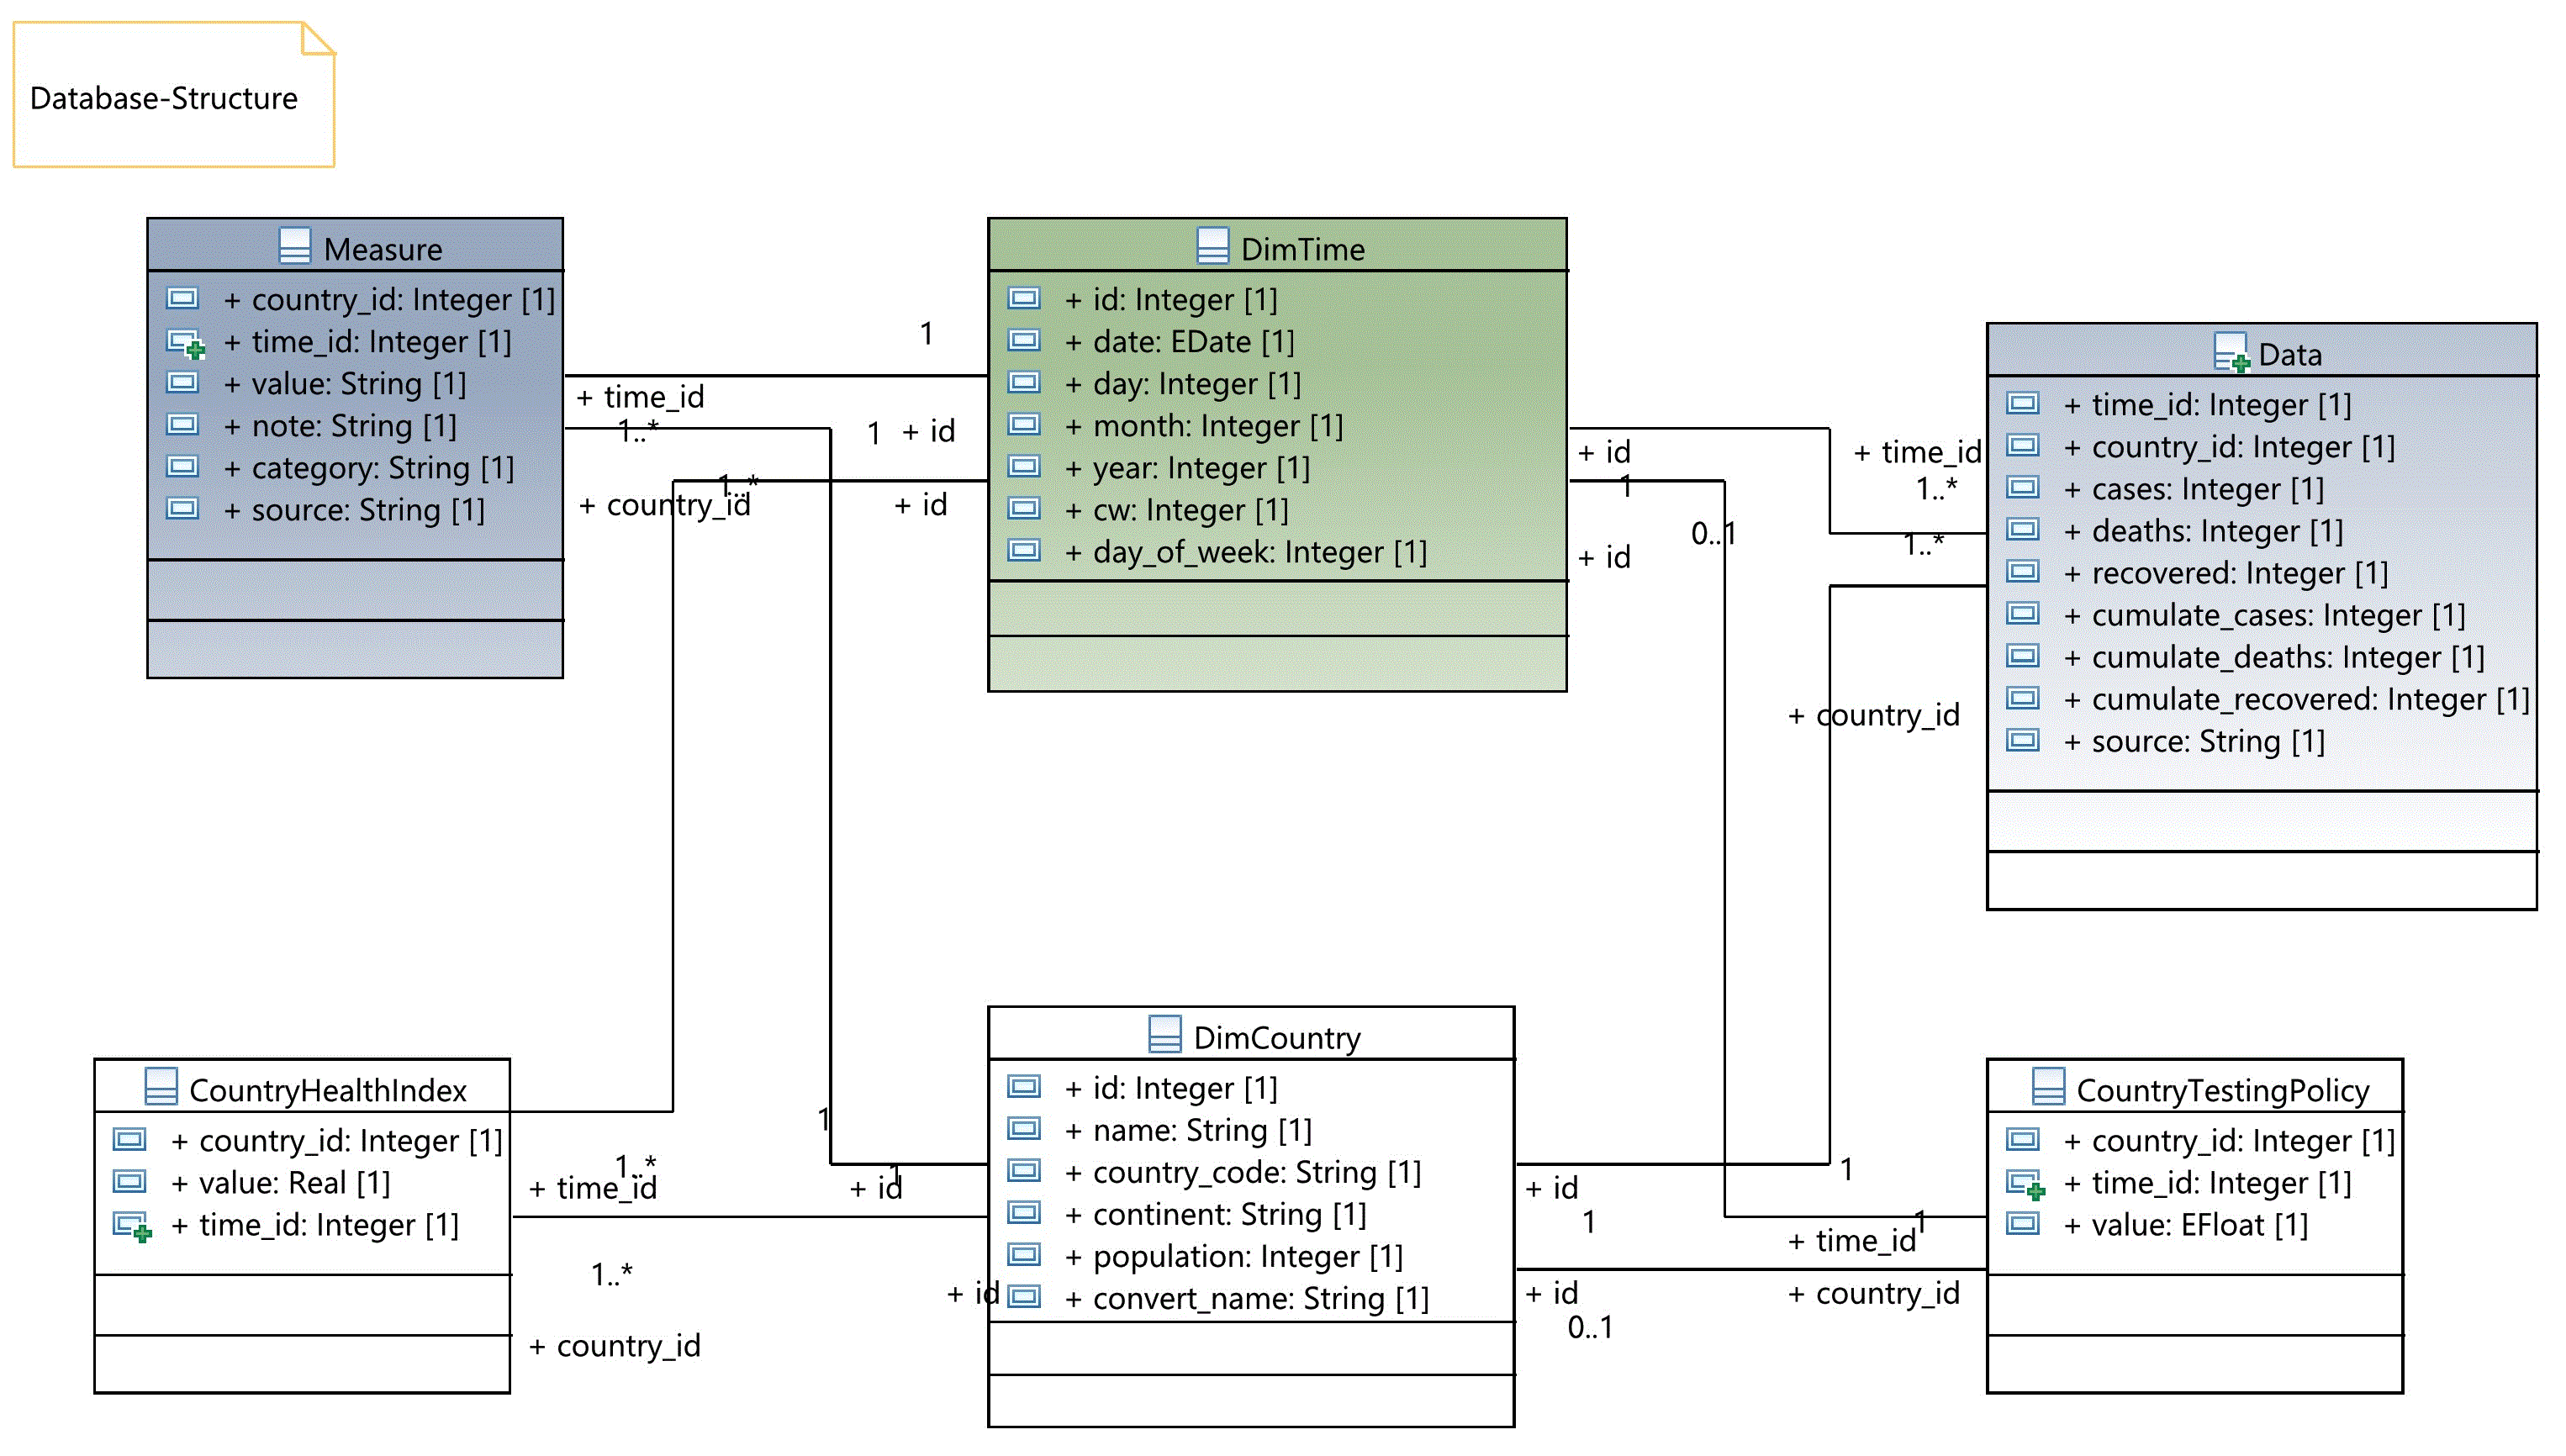

In [ ]:
# Databank related functions:

def read_dataset(connection,min_date,max_date,country,region): 
    df = pd.DataFrame()
    if (country == "all" or region == "all"):
        cq = "SELECT ROWID FROM DimCountry"
    else:              
        cq = "SELECT ROWID FROM DimCountry WHERE convert_name IN %s OR continent IN %s "%(country,region) 
    cid = pd.read_sql_query(cq,connection)
    sq = "SELECT DISTINCT source_id FROM data"
    sid = pd.read_sql_query(sq,connection)
    for n in range(cid.size):
        for m in range(sid.size):
            sql = "SELECT "\
                "dc.country_code "\
            	",dc.convert_name "\
                ",dc.continent "\
                ",dt.id "\
            	",dt.date "\
            	",CASE dt.day_of_week WHEN 1 THEN 'monday' "\
            	"					 WHEN 2 THEN 'tuesday' "\
            	"					 WHEN 3 THEN 'wednesday' "\
            	"					 WHEN 4 THEN 'thursday' "\
            	"					 WHEN 5 THEN 'friday' "\
            	"					 WHEN 6 THEN 'saturday' "\
            	"					 WHEN 7 THEN 'sunday' "\
            	"					 ELSE 'n/a' END day_of_week "\
            	",dt.cw calender_week "\
            	",d.cases "\
                ",d.deaths "\
                ",d.recovered "\
                ",d.cumulate_cases "\
                ",d.cumulate_deaths "\
                ",d.cumulate_recovered "\
                ",ds.name source "\
                "FROM DimTime dt "\
                "LEFT JOIN data d ON d.time_id = dt.id AND country_id = %i AND d.source_id = %i "\
                "LEFT JOIN DimCountry dc ON dc.ROWID = %i "\
                "LEFT JOIN DimSource ds ON ds.id = %i "\
                "WHERE dt.date BETWEEN '%s' AND '%s' "\
                "ORDER by dt.date"%(cid["rowid"][n],sid["source_id"][m],cid["rowid"][n],sid["source_id"][m],min_date,max_date)            
            tmp = pd.read_sql_query(sql,connection)
            df = pd.concat([tmp,df])    
            
    obj_columns = list(df.select_dtypes(include=['object']).columns.values)
    df[obj_columns] = df[obj_columns].replace([None], np.nan)
    return df

In [ ]:
# Database connection
path = "../input/covid19-database"    # Path to the database
db = path + '/database.db'
conn = sql.connect(db)                # SQL connection to the database
min_date = "2020-03-20"
max_date = "2020-06-30" 
data = read_dataset(conn,min_date,max_date,('all'),()) 
data

## Fitting and Prediction
For this task, we used data from cumulative cases. Under assumption that every person with a positive test result goes to quarantine, we fitted our model to data in ten-day periods. The data from the last ten days is used to evaluate the fitting results and to predict the trend of changes in states and parameters in the subsequent days.

To this aim, we implemented the function `data_fit_prediction(min_date, max_date, country, region, N, conn)` with the follwing in- and outputs:
-    In:
    - min_date; Begin date of the timespan (string, format: yyyy-mm-dd)
    - max_date; End date of the timespan (string, format: yyyy-mm-dd)
    - country; Name of selected countries (tuple of strings)
    - region; Name of selected region(s) (tuple of strings)
    - N; population of selected countries (intiger)
    - conn; SQL connection
-    Out:
    - S_f; Trend of changes in susceptible cases using fitted parameters
    - I_f; Trend of changes in infected cases using fitted parameters
    - Q; Quarantined cases from reported data
    - Q_f; Trend of changes in quarantined cases using fitted parameters
    - R; Recovered cases from reported data
    - R_f; Trend of changes in recovered cases using fitted parameters
    - D; Deceased cases from reported data
    - D_f; Trend of changes in deceased cases using fitted parameters
    - model_rest; List of predicted changes in model conditions
    - beta; Changes in infection rate
    - gamma; Inverse of latent time (fixed parameter)
    - delta; Changes in infected to quarantined rate
    - lambda; Recovery rate
    - kappa; Mortality rate
    - tspan_fit; Timespan of fitting
    - tspan_pred; Timespan of prediction
    - num_days; Total number of investigated timespan
    - rest; mod(num_days,10)

Knowing that the initial values of transition parameters may vary in different countries, we initialized the varying parameters such as, infection rate $\beta$, infected to quarantined rate $\delta$, recovery rate $\lambda$, and mortality rate $\kappa$, with a preliminary fitting with the data of the first ten days. 

In [ ]:
def data_fit_prediction(min_date,max_date, country, region, N,  conn):
    # Use query to get dataframe - Measure    
    # Database query 
    if np.size(country) == 1:
        countries = (country,'')
    else:
        countries = country
    
    if region == '':
        region = ()
    data = read_dataset(conn,min_date,max_date,countries,region)   
    # cw_data = data.groupby(['calender_week']).mean()
    day_data =data.groupby(data.index).mean()
    
    days = 10    # Data is analyzed in 10 days periods
    rest = np.mod(len(day_data), days)
    train_data = day_data[:-(10+rest)]
    tspan_fit = len(train_data.index) - np.mod(len(train_data),days)
    pred_data = day_data[-(10+rest):]
    
    # Assumption: Any person with a positive test result is in quarantine until their state changes.
    Q = day_data['cumulate_cases'].values - day_data['cumulate_recovered'].values - day_data['cumulate_deaths'].values
    R = day_data['cumulate_recovered'].values
    D = day_data['cumulate_deaths'].values
    I = day_data['cumulate_cases'].values
    
    # Memory reserve / Parameter initialization
    beta = np.zeros(int(tspan_fit/days)+1)
    beta[0] = 0.4
    delta = np.zeros(int(tspan_fit/days)+1)
    alpha = 0.05
    gamma = 0.4
    delta[0] = 0.04
    lamda = []
    kappa = []
    
    S_f = []
    I_f = []
    Q_f = []
    D_f = []
    R_f = []

    jj = 1
    
    # Initial states in the corresponding country
    Q_begin = Q[:days]
    R_begin = R[:days]
    D_begin = D[:days]
    initI = gamma*I[0] 
    initE = (1-gamma)*I[0]
    initP = alpha*N
    initS = N - (initE + initI + Q_begin[0] + R_begin[0] + D_begin[0] + initP)
    
    # Initial values of parameters may vary in different countries. 
    # The aim of following fitting is to prevent wrong initialization of infection rate, infected to quarantined rate, recovery rate and mortality rate
    tspan = np.linspace(0,days,days)
    fit, lambdafun, kappafun = model_fitting(alpha, beta[0], gamma, delta[0],[],[], Q_begin, R_begin, D_begin, initS, initE, initI, initP, tspan)
    beta[0] = fit.params['beta'].value
    delta[0] = fit.params['delta'].value
    lambdaGuess = [fit.params['lambda0'].value,fit.params['lambda1'].value,fit.params['lambda2'].value]
    kappaGuess = [fit.params['kappa0'].value,fit.params['kappa1'].value,fit.params['kappa2'].value]

    # Fitting in ten-day periods
    for ii in range(0,tspan_fit,days):
        tspan = np.linspace(0,days-1,days)
        Q_fit = Q[ii:days+ii]
        R_fit = R[ii:days+ii]
        D_fit = D[ii:days+ii]
        
        fit, lambdafun, kappafun = model_fitting(alpha, beta[jj-1], gamma, delta[jj-1],lambdaGuess, kappaGuess, Q_fit, R_fit, D_fit, initS, initE, initI, initP, tspan)
        #lmfit.report_fit(fit)
        
        # To prevent underfitting and adjust to sudden changes
        if fit.params['beta'].value < 1e-7:
            beta[jj] = beta[jj-1]
        else:
            beta[jj] = fit.params['beta'].value
        
        delta[jj] = fit.params['delta'].value
        lambdaGuess = fit.params['lambda0'].value,fit.params['lambda1'].value,fit.params['lambda2'].value
        lambda_tmp = days * [np.mean(lambdafun(lambdaGuess[0],lambdaGuess[1],lambdaGuess[2],tspan))]
        lamda= np.hstack((lamda,lambda_tmp))
        kappaGuess = fit.params['kappa0'].value,fit.params['kappa1'].value,fit.params['kappa2'].value
        kappa_tmp = days * [np.mean(kappafun(kappaGuess[0],kappaGuess[1],kappaGuess[2],tspan))]
        kappa = np.hstack((kappa, kappa_tmp))
        
        # Updating the initial conditions
        initial_conditions = [initS,initE, initI, Q_fit[0], R_fit[0], D_fit[0], initP]
        model = SEIQRDP(initial_conditions, fit.params, lambdafun, kappafun, tspan)
        S_f = np.hstack((S_f, model[:,0]))
        I_f = np.hstack((I_f, model[:,2]))
        Q_f = np.hstack((Q_f, model[:,3]))
        R_f = np.hstack((R_f,model[:,4]))
        D_f = np.hstack((D_f,model[:,5]))
        jj +=1
        initS = model[:,0][-1]
        initE = model[:,1][-1]
        initI = model[:,2][-1]
        initP = model[:,6][-1]
        
    del jj   
    

    
    
    # Time dimension
    num_days = len(day_data.index)
    tspan_pred = np.linspace(0,len(pred_data), len(pred_data)+1)
    # Prediction of rest + 10 days with the fitted parameters
    initial_conditions = [initS,initE, initI, Q_f[-1], R_f[-1], D_f[-1], initP]
    model_rest = SEIQRDP(initial_conditions,fit.params,lambdafun,kappafun,tspan_pred)
    S_f = np.hstack((S_f,model_rest[:,0][:-1]))    
    I_f = np.hstack((I_f,model_rest[:,2][:-1]))
    
    return S_f, I_f, Q, Q_f, R, R_f, D, D_f, model_rest, beta, gamma, delta, lamda, kappa, tspan_fit, tspan_pred, num_days, rest

# Results
We analyzed the data from Germany, Italy and Spain, and compared the dynamics of the parameters with the public interventions which have been taken in a timespan between March 20 and June 30. 

## Germany

In [ ]:
country = 'Germany'
region = ''
N = 83.02e06           # Population of Germany
min_date = "2020-03-20"
max_date = "2020-06-30" 

S_f, I_f, Q, Q_f, R, R_f, D, D_f, model_rest, beta, gamma,  delta, lamda, kappa, tspan_fit, tspan_pred, num_days, rest = data_fit_prediction(min_date,max_date, country, region, N,  conn)

first_day = datetime.strptime(min_date, '%Y-%m-%d')
date_list = [first_day + timedelta(days=x) for x in range(0, num_days)]
d_locator = mdates.DayLocator() 
fmt = mdates.DateFormatter('%b-%d')
plt.style.use('fivethirtyeight') 

In [ ]:
# Plotting
Q_f_rest = model_rest[:,3]
R_f_rest = model_rest[:,4]
D_f_rest = model_rest[:,5]

fig,ax = plt.subplots(1,1,figsize=(12,8)) 

ax.plot(date_list,Q,'d',color='dimgrey',label='Data')
ax.plot(date_list[:tspan_fit],Q_f,color='darkorange', lw=3,label='Quarantined cases')
ax.plot(date_list[tspan_fit-1:],Q_f_rest,'--',color='darkorange',lw=3) 
ax.fill_between(date_list[:tspan_fit],0.875*Q_f,1.125*Q_f,alpha=0.3,color='orange') 
ax.fill_between(date_list[tspan_fit-1:],0.875*Q_f_rest,1.125*Q_f_rest,alpha=0.3,color='orange') 
ax.fill_between(date_list[tspan_fit-1:],0.93*Q_f_rest,1.07*Q_f_rest,alpha=0.4,color='orange') 

ax.plot(date_list,I_f,color='darkmagenta', lw=3,label='Infected cases')

ax.plot(date_list,R,'d',color='dimgrey')
ax.plot(date_list[:tspan_fit],R_f,color='green', lw=3,label='Recovered cases')
ax.plot(date_list[tspan_fit-1:],R_f_rest,'--',color='green',lw=3) 
ax.fill_between(date_list[:tspan_fit],0.875*R_f,1.125*R_f,alpha=0.3,color='limegreen') 
ax.fill_between(date_list[tspan_fit-1:],0.875*R_f_rest,1.125*R_f_rest,alpha=0.3,color='limegreen') 
ax.fill_between(date_list[tspan_fit-1:],0.93*R_f_rest,1.07*R_f_rest,alpha=0.4,color='limegreen') 

ax.plot(date_list,D,'d',color='dimgrey')
ax.plot(date_list[:tspan_fit],D_f,color='red', lw=3,label='Fetalities')
ax.plot(date_list[tspan_fit-1:],D_f_rest,'--',color='red',lw=3) 
ax.fill_between(date_list[:tspan_fit],0.875*D_f,1.125*D_f,alpha=0.3,color='salmon') 
ax.fill_between(date_list[tspan_fit-1:],0.875*D_f_rest,1.125*D_f_rest,alpha=0.3,color='salmon') 
ax.fill_between(date_list[tspan_fit-1:],0.93*D_f_rest,1.07*D_f_rest,alpha=0.4,color='salmon') 

ax.set_title('Cases in '+country, fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.autoscale(enable=True, axis='x', tight=True)
ax.legend()
ax.xaxis.set_minor_locator(d_locator)
ax.xaxis.set_major_formatter(fmt)
fig.autofmt_xdate()

If we look more closely at the changes of infected and quarantined cases between March 20 and June 30, and compare them with the trend of changes in the effective reproduction number, we can draw two conclusions:
* The increasing number of the infected cases in the beginning of April is controlled and begins to fall due to the social lockdown, and the reproduction number reaches $R(t)<1$
* As in the beginning of May the number of infected cases begins to gradually increase, the obligatory social distancing and partial lockdown in Germany, which has been taken until 15. May, controls this rising trend. The latter can also be seen in the changes of effective reproduction number as its value decreases and remains below one.

In [ ]:
s_fit = np.zeros((int(num_days/10)+1,))
jj = 0
for ii in range(0,len(S_f),10):
    s_fit[jj] = np.mean(S_f[ii:ii+10])   
    jj += 1
del jj
# Calculating the reproduction number
Rt = beta*s_fit[:-1]/(delta*N)

In [ ]:
# I&Q vs R(t)
fig, axes = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [3,7]})

ax = axes[1]
ax.plot(date_list[:num_days],Q,'d',color='dimgrey',label='Data')
ax.plot(date_list[:tspan_fit],Q_f,color='darkorange', lw=3,label='Quarantined cases')
ax.plot(date_list[tspan_fit-1:],Q_f_rest,'--',color='darkorange',lw=3) 
ax.fill_between(date_list[:tspan_fit],0.875*Q_f,1.125*Q_f,alpha=0.3,color='orange') 
ax.fill_between(date_list[tspan_fit-1:],0.875*Q_f_rest,1.125*Q_f_rest,alpha=0.3,color='orange') 
ax.fill_between(date_list[tspan_fit-1:],0.93*Q_f_rest,1.07*Q_f_rest,alpha=0.4,color='orange') 
ax.set_title('Quarantined cases vs. Infected cases in '+country, fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.plot(date_list,I_f,color='darkmagenta', lw=3,label='Infected cases')
ax.autoscale(enable=True, axis='x', tight=True)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax.xaxis.set_minor_locator(d_locator)
ax.xaxis.set_major_formatter(fmt)

ax = axes[0]
ax.plot(date_list[0:tspan_fit:9], Rt)
ax.fill_between(date_list[0:tspan_fit:9],0.93*Rt,1.07*Rt,alpha=0.4,color='skyblue') 
ax.plot(date_list[0:tspan_fit:9], len(date_list[0:tspan_fit:9])*[1],'--', color='royalblue', lw=1)
ax.set_title(r'Effective reproduction number in '+country+' - $R(t)$', fontsize=16)
ax.autoscale(enable=True, axis='x', tight=True)
ax.xaxis.set_minor_locator(d_locator)
ax.xaxis.set_major_formatter(fmt)

fig.autofmt_xdate()

## Italy

In [ ]:
country = 'Italy'
region = ''
N = 60.36e06            # Population of Italy
min_date = "2020-03-20"
max_date = "2020-06-30" 

S_f, I_f, Q, Q_f, R, R_f, D, D_f, model_rest, beta, gamma,  delta, lamda, kappa, tspan_fit, tspan_pred, num_days, rest = data_fit_prediction(min_date,max_date, country, region, N,  conn)

first_day = datetime.strptime(min_date, '%Y-%m-%d')
date_list = [first_day + timedelta(days=x) for x in range(0, num_days)]
d_locator = mdates.DayLocator() 
fmt = mdates.DateFormatter('%b-%d')
plt.style.use('fivethirtyeight') 

In [ ]:
# Plotting
Q_f_rest = model_rest[:,3]
R_f_rest = model_rest[:,4]
D_f_rest = model_rest[:,5]

fig,ax = plt.subplots(1,1,figsize=(12,8)) 

ax.plot(date_list,Q,'d',color='dimgrey',label='Data')
ax.plot(date_list[:tspan_fit],Q_f,color='darkorange', lw=3,label='Quarantined cases')
ax.plot(date_list[tspan_fit-1:],Q_f_rest,'--',color='darkorange',lw=3) 
ax.fill_between(date_list[:tspan_fit],0.875*Q_f,1.125*Q_f,alpha=0.3,color='orange') 
ax.fill_between(date_list[tspan_fit-1:],0.875*Q_f_rest,1.125*Q_f_rest,alpha=0.3,color='orange') 
ax.fill_between(date_list[tspan_fit-1:],0.93*Q_f_rest,1.07*Q_f_rest,alpha=0.4,color='orange') 

ax.plot(date_list,I_f,color='darkmagenta', lw=3,label='Infected cases')

ax.plot(date_list,R,'d',color='dimgrey')
ax.plot(date_list[:tspan_fit],R_f,color='green', lw=3,label='Recovered cases')
ax.plot(date_list[tspan_fit-1:],R_f_rest,'--',color='green',lw=3) 
ax.fill_between(date_list[:tspan_fit],0.875*R_f,1.125*R_f,alpha=0.3,color='limegreen') 
ax.fill_between(date_list[tspan_fit-1:],0.875*R_f_rest,1.125*R_f_rest,alpha=0.3,color='limegreen') 
ax.fill_between(date_list[tspan_fit-1:],0.93*R_f_rest,1.07*R_f_rest,alpha=0.4,color='limegreen') 

ax.plot(date_list,D,'d',color='dimgrey')
ax.plot(date_list[:tspan_fit],D_f,color='red', lw=3,label='Fetalities')
ax.plot(date_list[tspan_fit-1:],D_f_rest,'--',color='red',lw=3) 
ax.fill_between(date_list[:tspan_fit],0.875*D_f,1.125*D_f,alpha=0.3,color='salmon') 
ax.fill_between(date_list[tspan_fit-1:],0.875*D_f_rest,1.125*D_f_rest,alpha=0.3,color='salmon') 
ax.fill_between(date_list[tspan_fit-1:],0.93*D_f_rest,1.07*D_f_rest,alpha=0.4,color='salmon') 

ax.set_title('Cases in '+country, fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.autoscale(enable=True, axis='x', tight=True)
ax.legend()
ax.xaxis.set_minor_locator(d_locator)
ax.xaxis.set_major_formatter(fmt)
fig.autofmt_xdate()

Considering the changes of infected and quarantined cases in Italy and comparing them with the trend of changes of effective reproduction number in the corresponding timespan, we can see that the spreading of the virus is well controlled until about May 1, and the effective reproduction number had reached values less than one.


However, as the number of quarantined cases decrease, the effective reproduction number increases rapidly and reaches values near to one, which may indicate the instant need for further social interventions such as social distancing.

In [ ]:
s_fit = np.zeros((int(num_days/10)+1,))
jj = 0
for ii in range(0,len(S_f),10):
    s_fit[jj] = np.mean(S_f[ii:ii+10])   
    jj += 1
del jj
# Calculating the reproduction number
Rt = beta*s_fit[:-1]/(delta*N)

In [ ]:
# I&Q vs R(t)
fig, axes = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [3,7]})

ax = axes[1]
ax.plot(date_list[:num_days],Q,'d',color='dimgrey',label='Data')
ax.plot(date_list[:tspan_fit],Q_f,color='darkorange', lw=3,label='Quarantined cases')
ax.plot(date_list[tspan_fit-1:],Q_f_rest,'--',color='darkorange',lw=3) 
ax.fill_between(date_list[:tspan_fit],0.875*Q_f,1.125*Q_f,alpha=0.3,color='orange') 
ax.fill_between(date_list[tspan_fit-1:],0.875*Q_f_rest,1.125*Q_f_rest,alpha=0.3,color='orange') 
ax.fill_between(date_list[tspan_fit-1:],0.93*Q_f_rest,1.07*Q_f_rest,alpha=0.4,color='orange') 
ax.set_title('Quarantined cases vs. Infected cases in '+country, fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.plot(date_list,I_f,color='darkmagenta', lw=3,label='Infected cases')
ax.autoscale(enable=True, axis='x', tight=True)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax.xaxis.set_minor_locator(d_locator)
ax.xaxis.set_major_formatter(fmt)

ax = axes[0]
ax.plot(date_list[0:tspan_fit:9], Rt)
ax.fill_between(date_list[0:tspan_fit:9],0.93*Rt,1.07*Rt,alpha=0.4,color='skyblue') 
ax.plot(date_list[0:tspan_fit:9], len(date_list[0:tspan_fit:9])*[1],'--', color='royalblue', lw=1)
ax.set_title(r'Effective reproduction number in '+country+' - $R(t)$', fontsize=16)
ax.autoscale(enable=True, axis='x', tight=True)
ax.xaxis.set_minor_locator(d_locator)
ax.xaxis.set_major_formatter(fmt)

fig.autofmt_xdate()

## Spain

In [ ]:
country = 'Spain'
region = ''
N = 46.94e06            # Population of Spain
min_date = "2020-03-20"
max_date = "2020-06-30" 

S_f, I_f, Q, Q_f, R, R_f, D, D_f, model_rest, beta, gamma,  delta, lamda, kappa, tspan_fit, tspan_pred, num_days, rest = data_fit_prediction(min_date,max_date, country, region, N,  conn)

first_day = datetime.strptime(min_date, '%Y-%m-%d')
date_list = [first_day + timedelta(days=x) for x in range(0, num_days)]
d_locator = mdates.DayLocator() 
fmt = mdates.DateFormatter('%b-%d')
plt.style.use('fivethirtyeight') 

In [ ]:
# Plotting
Q_f_rest = model_rest[:,3]
R_f_rest = model_rest[:,4]
D_f_rest = model_rest[:,5]

fig,ax = plt.subplots(1,1,figsize=(12,8)) 

ax.plot(date_list,Q,'d',color='dimgrey',label='Data')
ax.plot(date_list[:tspan_fit],Q_f,color='darkorange', lw=3,label='Quarantined cases')
ax.plot(date_list[tspan_fit-1:],Q_f_rest,'--',color='darkorange',lw=3) 
ax.fill_between(date_list[:tspan_fit],0.875*Q_f,1.125*Q_f,alpha=0.3,color='orange') 
ax.fill_between(date_list[tspan_fit-1:],0.875*Q_f_rest,1.125*Q_f_rest,alpha=0.3,color='orange') 
ax.fill_between(date_list[tspan_fit-1:],0.93*Q_f_rest,1.07*Q_f_rest,alpha=0.4,color='orange') 

ax.plot(date_list,I_f,color='darkmagenta', lw=3,label='Infected cases')

ax.plot(date_list,R,'d',color='dimgrey')
ax.plot(date_list[:tspan_fit],R_f,color='green', lw=3,label='Recovered cases')
ax.plot(date_list[tspan_fit-1:],R_f_rest,'--',color='green',lw=3) 
ax.fill_between(date_list[:tspan_fit],0.875*R_f,1.125*R_f,alpha=0.3,color='limegreen') 
ax.fill_between(date_list[tspan_fit-1:],0.875*R_f_rest,1.125*R_f_rest,alpha=0.3,color='limegreen') 
ax.fill_between(date_list[tspan_fit-1:],0.93*R_f_rest,1.07*R_f_rest,alpha=0.4,color='limegreen') 

ax.plot(date_list,D,'d',color='dimgrey')
ax.plot(date_list[:tspan_fit],D_f,color='red', lw=3,label='Fetalities')
ax.plot(date_list[tspan_fit-1:],D_f_rest,'--',color='red',lw=3) 
ax.fill_between(date_list[:tspan_fit],0.875*D_f,1.125*D_f,alpha=0.3,color='salmon') 
ax.fill_between(date_list[tspan_fit-1:],0.875*D_f_rest,1.125*D_f_rest,alpha=0.3,color='salmon') 
ax.fill_between(date_list[tspan_fit-1:],0.93*D_f_rest,1.07*D_f_rest,alpha=0.4,color='salmon') 

ax.set_title('Cases in '+country, fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.autoscale(enable=True, axis='x', tight=True)
ax.legend()
ax.xaxis.set_minor_locator(d_locator)
ax.xaxis.set_major_formatter(fmt)
fig.autofmt_xdate()

The low value of the effective reproduction number in Spain during April 1 until around May 1 shows the effectiveness of the full lockdown on April 4 and April 13.

However, with the significant rise of $R(t)$ and the number of infected cases in the first half of May, partial lockdowns, movement restrictions and other social interventions were only able to impact the course of the pandemic after a relatively long delay, so the effective reproduction number only dropped below one again in the last days of June.

In [ ]:
s_fit = np.zeros((int(num_days/10)+1,))
jj = 0
for ii in range(0,len(S_f),10):
    s_fit[jj] = np.mean(S_f[ii:ii+10])   
    jj += 1
del jj
# Calculating the reproduction number
Rt = beta*s_fit[:-1]/(delta*N)

In [ ]:
# I&Q vs R(t)
fig, axes = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [3,7]})

ax = axes[1]
ax.plot(date_list[:num_days],Q,'d',color='dimgrey',label='Data')
ax.plot(date_list[:tspan_fit],Q_f,color='darkorange', lw=3,label='Quarantined cases')
ax.plot(date_list[tspan_fit-1:],Q_f_rest,'--',color='darkorange',lw=3) 
ax.fill_between(date_list[:tspan_fit],0.875*Q_f,1.125*Q_f,alpha=0.3,color='orange') 
ax.fill_between(date_list[tspan_fit-1:],0.875*Q_f_rest,1.125*Q_f_rest,alpha=0.3,color='orange') 
ax.fill_between(date_list[tspan_fit-1:],0.93*Q_f_rest,1.07*Q_f_rest,alpha=0.4,color='orange') 
ax.set_title('Quarantined cases vs. Infected cases in '+country, fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.plot(date_list,I_f,color='darkmagenta', lw=3,label='Infected cases')
ax.autoscale(enable=True, axis='x', tight=True)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax.xaxis.set_minor_locator(d_locator)
ax.xaxis.set_major_formatter(fmt)

ax = axes[0]
ax.plot(date_list[0:tspan_fit:9], Rt)
ax.fill_between(date_list[0:tspan_fit:9],0.93*Rt,1.07*Rt,alpha=0.4,color='skyblue') 
ax.plot(date_list[0:tspan_fit:9], len(date_list[0:tspan_fit:9])*[1],'--', color='royalblue', lw=1)
ax.set_title(r'Effective reproduction number in '+country+' - $R(t)$', fontsize=16)
ax.autoscale(enable=True, axis='x', tight=True)
ax.xaxis.set_minor_locator(d_locator)
ax.xaxis.set_major_formatter(fmt)

fig.autofmt_xdate()

# Future Works
We analyzed the data from reported cumulative infected, recovered, and deceased cases and evaluated the impact of taken social interventions in Germany, Italy and Spain, using the effective reproduction number. 

The proposed model could also be used to evaluate the role of the health care system across countries, using the recovery and mortality rate and comparing them with the effective reproduction number and also the health index of any specific country. 

Furthurmore, many other fitting methods, using the Markov property of the system, can be used to prevent overfitting and to adjust the model to sudden changes in the trends.

# Refrences
* [A time-dependent SEIR model to analyse the evolution of the SARS-covid-2 epidemic outbreak in Portugal](http://dx.doi.org/10.2471/BLT.20.258392)
* [Modellierung von Beispielszenarien der SARS-CoV-2-Epidemie 2020 in Deutschland](http://dx.doi.org/10.25646/6571.2)
* [Generalized SEIR Epidemic Model (fitting and computation in MATLAB)](https://de.mathworks.com/matlabcentral/fileexchange/74545-generalized-seir-epidemic-model-fitting-and-computation)
